In [1]:
# Make animations with instructions here:
# http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/

%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.integrate import odeint
import scipy.special as special

Populating the interactive namespace from numpy and matplotlib


In [2]:
##############################################
#        Exact system of equations           #
#         for solving numerically            #
##############################################

def conservative_spin(y, t, q, Momega):  
    """9 ODE's for Lhat, S1, S2.
    t is a dummy variable required for solveode.
    """
    
    Lhatx, Lhaty, Lhatz, S1x, S1y, S1z, S2x, S2y, S2z = y
    
    eta = q/(1.+q)**2
    v = Momega**(1./3.)
    
    # Dot and cross products
    S1dotLhat = S1x*Lhatx + S1y*Lhaty + S1z*Lhatz
    S2dotLhat = S2x*Lhatx + S2y*Lhaty + S2z*Lhatz
    
    S1crossLhat_x = S1y*Lhatz - S1z*Lhaty
    S1crossLhat_y = S1z*Lhatx - S1x*Lhatz
    S1crossLhat_z = S1x*Lhaty - S1y*Lhatx
    
    S2crossLhat_x = S2y*Lhatz - S2z*Lhaty
    S2crossLhat_y = S2z*Lhatx - S2x*Lhatz
    S2crossLhat_z = S2x*Lhaty - S2y*Lhatx
    
    S1crossS2_x = S1y*S2z - S1z*S2y
    S1crossS2_y = S1z*S2x - S1x*S2z
    S1crossS2_z = S1x*S2y - S1y*S2x
    
    # The system of equations
    G1 = ( (2. + 3.*q/2.) - 3.*v/(2.*eta)*(q*S1dotLhat + S2dotLhat) )
    G2 = ( (2. + 3./(2.*q)) - 3.*v/(2.*eta)*(S1dotLhat + S2dotLhat/q) )
    
    Lhatxdot = (G1*S1crossLhat_x + G2*S2crossLhat_x)*v**6
    Lhatydot = (G1*S1crossLhat_y + G2*S2crossLhat_y)*v**6
    Lhatzdot = (G1*S1crossLhat_z + G2*S2crossLhat_z)*v**6
    
    S1xdot = -eta*G1*v**5*S1crossLhat_x - 0.5*v**6*S1crossS2_x
    S1ydot = -eta*G1*v**5*S1crossLhat_y - 0.5*v**6*S1crossS2_y
    S1zdot = -eta*G1*v**5*S1crossLhat_z - 0.5*v**6*S1crossS2_z
    
    S2xdot = -eta*G2*v**5*S2crossLhat_x + 0.5*v**6*S1crossS2_x
    S2ydot = -eta*G2*v**5*S2crossLhat_y + 0.5*v**6*S1crossS2_y
    S2zdot = -eta*G2*v**5*S2crossLhat_z + 0.5*v**6*S1crossS2_z
    
    return np.array([Lhatxdot, Lhatydot, Lhatzdot, S1xdot, S1ydot, S1zdot, S2xdot, S2ydot, S2zdot])

# Analytic solution

You have flipped the sign of the rotation $\phi'$ about the $y$-axis to get $\vec S_1$ and $\vec S_2$, and the sign of $\sin(\phi')$. These 2 'wrong' changes give the answer that agrees with the numerical solution. Figure out what the corroct thing to do is.  

In [63]:
##############################################
#           Geometric functions              #
##############################################

def polar_to_cartesian(r, theta, phi):
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)
    return x, y, z


def cartesian_to_polar(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.arctan2(y, x)
    return r, theta, phi

# !!!!! Make sure the angle phi (in range [-pi, pi]) is the correct range
# to put into unwrap function. !!!!!!!!!
def cartesian_to_polar_unwrap(x, y, z):
    r, theta, phi = cartesian_to_polar(x, y, z)
    return r, theta, np.unwrap(phi)


def normalize(x, y, z):
    """convert vector to unit vector.
    """
    norm = np.sqrt(x**2 + y**2 + z**2)
    return x/norm, y/norm, z/norm


##############################################
#            Rotation functions              #
##############################################

def rotate_about_x(Vx, Vy, Vz, theta):
    """Rotate the vector V a + angle theta about the + x-axis. 
    """    
    Vynew = Vy*np.cos(theta) - Vz*np.sin(theta)
    Vznew = Vy*np.sin(theta) + Vz*np.cos(theta)
    
    Vxnew = Vx
    return Vxnew, Vynew, Vznew

# def rotate_about_y(Vx, Vy, Vz, theta):
#     """Rotate the vector V a + angle theta about the + y-axis. 
#     """    
#     Vznew = Vz*np.cos(theta) - Vx*np.sin(theta)
#     Vxnew = Vz*np.sin(theta) + Vx*np.cos(theta)
    
#     Vynew = Vy
#     return Vxnew, Vynew, Vznew

def rotate_about_y(Vx, Vy, Vz, theta):
    """Rotate the vector V a + angle theta about the + y-axis. 
    """    
    Vxnew = Vx*np.cos(theta) + Vz*np.sin(theta)
    Vznew = -Vx*np.sin(theta) + Vz*np.cos(theta)
    
    Vynew = Vy
    return Vxnew, Vynew, Vznew

def rotate_about_z(Vx, Vy, Vz, theta):
    """Rotate the vector V a + angle theta about the + z-axis. 
    """    
    Vxnew = Vx*np.cos(theta) - Vy*np.sin(theta)
    Vynew = Vx*np.sin(theta) + Vy*np.cos(theta)
    
    Vznew = Vz
    return Vxnew, Vynew, Vznew


##############################################
#         Angular momentum functions         #
##############################################

def total_spin(y):
    """Get total spin angular momentum S = S1 + S2
    from the 9 cartesian components.
    """
    Lhatx, Lhaty, Lhatz, S1x, S1y, S1z, S2x, S2y, S2z = y
    Sx = S1x + S2x
    Sy = S1y + S2y
    Sz = S1z + S2z
    return Sx, Sy, Sz


def orbital_angular_momentum(y, L):
    """Get total angular momentum J = L + S1 + S2
    from the 9 cartesian components.
    """
    Lhatx, Lhaty, Lhatz, S1x, S1y, S1z, S2x, S2y, S2z = y
    Lx, Ly, Lz = L*Lhatx, L*Lhaty, L*Lhatz
    return Lx, Ly, Lz


def total_angular_momentum(y, L):
    """Get total angular momentum J = L + S1 + S2
    from the 9 cartesian components.
    """
    Lhatx, Lhaty, Lhatz, S1x, S1y, S1z, S2x, S2y, S2z = y
    Lx, Ly, Lz = L*Lhatx, L*Lhaty, L*Lhatz
    Jx = Lx + S1x + S2x
    Jy = Ly + S1y + S2y
    Jz = Lz + S1z + S2z
    return Jx, Jy, Jz


def effective_spin(y, q):
    """The effective spin xi. 
    Conserved when there is no radiation reaction.
    """
    Lhatx, Lhaty, Lhatz, S1x, S1y, S1z, S2x, S2y, S2z = y
        
    S1dotLhat = S1x*Lhatx + S1y*Lhaty + S1z*Lhatz
    S2dotLhat = S2x*Lhatx + S2y*Lhaty + S2z*Lhatz
    
    return (1.+q)*S1dotLhat + (1.+1./q)*S2dotLhat

In [4]:
def all_interesting_quantities(y, L, q):
    """return a dictionary of all interesting time series.
    """
    Lhatx, Lhaty, Lhatz, S1x, S1y, S1z, S2x, S2y, S2z = y
    Sx, Sy, Sz = total_spin(y)
    Lx, Ly, Lz = orbital_angular_momentum(y, L)
    Jx, Jy, Jz = total_angular_momentum(y, L)
    xi = effective_spin(y, q)
    
    # Polar quantities
    Lhat, theta_Lhat, phi_Lhat = cartesian_to_polar(Lhatx, Lhaty, Lhatz)
    S1, theta_S1, phi_S1 = cartesian_to_polar(S1x, S1y, S1z)
    S2, theta_S2, phi_S2 = cartesian_to_polar(S2x, S2y, S2z)
    
    L, theta_L, phi_L = cartesian_to_polar(Lx, Ly, Lz)
    S, theta_S, phi_S = cartesian_to_polar(Sx, Sy, Sz)
    J, theta_J, phi_J = cartesian_to_polar(Jx, Jy, Jz)
    
    return {'Lhatx': Lhatx, 'Lhaty': Lhaty, 'Lhatz': Lhatz, 
           'S1x': S1x, 'S1y': S1y, 'S1z': S1z, 
           'S2x': S2x, 'S2y': S2y, 'S2z': S2z, 
           'Sx': Sx, 'Sy': Sy, 'Sz': Sz, 
           'Lx': Lx, 'Ly': Ly, 'Lz': Lz, 
           'Jx': Jx, 'Jy': Jy, 'Jz': Jz, 
           'xi': xi, 
           'Lhat': Lhat, 'theta_Lhat': theta_Lhat, 'phi_Lhat': phi_Lhat, 
           'S1': S1, 'theta_S1': theta_S1, 'phi_S1': phi_S1, 
           'S2': S2, 'theta_S2': theta_S2, 'phi_S2': phi_S2, 
           'L': L, 'theta_L': theta_L, 'phi_L': phi_L, 
           'S': S, 'theta_S': theta_S, 'phi_S': phi_S, 
           'J': J, 'theta_J': theta_J, 'phi_J': phi_J}

In [15]:
##############################################
#         Solution to S^2 and \phi_z         #
##############################################

def spin_squared_roots(S1, S2, L, J, q, eta, deltam, xi):
    """Find the 3 roots of S^2 in the equation for (dS^2/dt)^2.
    """
    B = (L**2+S1**2)*q + 2*L*xi - 2.*J**2 - S1**2 - S2**2 + (L**2 + S2**2)/q
    
    C = (J**2-L**2)**2 - 2*L*xi*(J**2-L**2) \
        - 2.*(1.-q)/q * (S1**2-q*S2**2)*L**2 + 4.*eta*L**2*xi**2 \
        - 2.*deltam*(S1**2-S2**2)*xi*L + 2.*(1.-q)/q * (q*S1**2-S2**2)*J**2
    
    D = (1.-q)/q * (S2**2-q*S1**2)*(J**2-L**2)**2 \
        + deltam**2/eta * (S1**2-S2**2)**2*L**2 \
        + 2.*deltam*L*xi*(S1**2-S2**2)*(J**2-L**2)
    
    S3sq, Smsq, Spsq = np.sort(np.roots([1., B, C, D]))
    return S3sq, Smsq, Spsq


def A_total_spin_term(eta, xi, v):
    return -3./(2.*np.sqrt(eta)) * v**6 * (1.-xi*v)


def total_spin_magnitude(t, Momega, eta, xi, S3sq, Smsq, Spsq):
    """S = |S1+S2| at time t when S1 and S2 both start in the y-z plane at t=0.
    """
    v = Momega**(1./3.)
    #A = -3./(2.*np.sqrt(eta)) * v**6 * (1.-xi*v)
    A = A_total_spin_term(eta, xi, v)
    m = (Spsq-Smsq) / (Spsq-S3sq)
    psibyt = 0.5*A*np.sqrt(Spsq-S3sq)
    sn, cn, dn, ph = special.ellipj(psibyt*t, m)
    Soft = np.sqrt(Spsq + (Smsq-Spsq)*sn**2)
    return Soft, sn, cn


def phi_z_dot(phi_z, t, Momega, eta, xi, J, S1, S2, S3sq, Smsq, Spsq):
    """The ode for phi_z.
    Solving it numerically for now.
    """
    v = Momega**(1./3.)
    A = A_total_spin_term(eta, xi, v)
    m = (Spsq-Smsq) / (Spsq-S3sq)
    psibyt = 0.5*A*np.sqrt(Spsq-S3sq)
    sn, cn, dn, ph = special.ellipj(psibyt*t, m)
    
    # Calculate the coefficients
    a = 0.5*v**6 * ( 1. + 3./(2.*eta)*(1.-xi*v) )
    
    c0 = 3./4.*(1.-xi*v)*v**2 * (eta**3 + 4.*eta**3*xi*v - 2.*eta*(J**2-Spsq + 2.*(S1**2-S2**2)*deltam)*v**2 \
                                -4.*eta*xi*(J**2-Spsq)*v**3 + (J**2-Spsq)**2*v**4/eta)
    
    c2 = -3.*eta/2. * (Spsq-Smsq) * (1. + 2.*xi*v - (J**2-Spsq)*v**2/eta**2) * (1.-xi*v)*v**4
    
    c4 = 3./(4.*eta) * (Spsq-Smsq)**2 * (1.-xi*v)*v**6
    
    # Sp and not Spsq here
    Sp = np.sqrt(Spsq)
    d0 = -(J**2 - (L+Sp)**2) * (J**2 - (L-Sp)**2)
    
    d2 = -2.*(Spsq-Smsq) * (J**2 + L**2 - Spsq)

    d4 = -(Spsq-Smsq)**2

    phidot_J = a + (c0 + c2*sn**2 + c4*sn**4)/(d0 + d2*sn**2 + d4*sn**4)
    return J * phidot_J


def phi_z(t, Momega, eta, xi, J, S1, S2, S3sq, Smsq, Spsq):
    """Solving phi_z numerically for now.
    """
    phiz0 = 0.0
    sol_phiz, info = odeint(phi_z_dot, phiz0, t, args=(Momega, eta, xi, J, S1, S2, S3sq, Smsq, Spsq), full_output=True)
    return sol_phiz.T[0]

In [82]:
##############################################
# Evaluate $\hat L$, $\vec S_1$, $\vec S_2$  # 
# In terms of solutions to S^2 and \phi_z.   #
##############################################

### The angle between vectors holds in any frame, so drop the frame name. ###
# Call this theta_JL.
def theta_orbital_xyz(J, L, S):
    """The angle \theta_L between vecJ and vecL.
    """
    costheta = (J**2 + L**2 - S**2) / (2.*J*L)
    return np.arccos(costheta)


def cartesian_orbital_xyz(J, L, S):
    theta_L = theta_orbital_xyz(J, L, S)
    return L*np.sin(theta_L), np.zeros(len(theta_L)), L*np.cos(theta_L)


def cartesian_total_spin_xyz(J, L, S):
    """
    """
    theta_L = theta_orbital_xyz(J, L, S)
    return -L*np.sin(theta_L), np.zeros(len(theta_L)), J-L*np.cos(theta_L)


### The angle between vectors holds in any frame, so drop the frame name. ###
# Call this theta_JS.
def theta_total_spin_xyz(J, L, S):
    """The angle \theta_S between vecJ and vecS 
    (total spin vecS = vecS1 + vecS2).
    """
    costheta = (J**2 + S**2 - L**2) / (2.*J*S)
    return np.arccos(costheta)


### The angle between vectors holds in any frame, so drop the frame name. ###
# Call this theta_SS1.
def theta_SS1(S, S1, S2):
    """The angle \theta' between vecS and vecS1.
    This is also the polar angle of vecS1 in the x'y'z' frame
    (where vecS defines the z'-axis).
    """
    costheta = (S**2 + S1**2 - S2**2) / (2.*S*S1)
    return np.arccos(costheta)


# ### This angle, however, is the azimuthal angle in the x'y'z' coordinate system. ###
# ### It depends on the frame, so keep the frame name. ###
# def phi_prime_spin1_xyzprime(J, L, S, S1, S2, q, xi):
#     """The azimuthal angle phi' in the x'y'z' frame 
#     (where vecS defines the z'-axis).
#     """
#     A1 = np.sqrt(J**2 - (L-S)**2)
#     A2 = np.sqrt((L+S)**2 - J**2)
#     A3 = np.sqrt(S**2 - (S1-S2)**2)
#     A4 = np.sqrt((S1+S2)**2 - S**2)
    
#     num = (J**2-L**2-S**2) * (S**2*(1.+q)**2 - (S1**2-S2**2)*(1.-q**2)) - 4.*q*S**2*L*xi
#     den = (1.-q**2)*A1*A2*A3*A4
#     cp = num/den
    
#     # Deal with round off error
#     cp[cp<-1.] = -1.
#     cp[cp>1.] = 1.
#     return np.arccos(cp)


### This angle, however, is the azimuthal angle in the x'y'z' coordinate system. ###
### It depends on the frame, so keep the frame name. ###
def cos_phi_prime_spin1_xyzprime(J, L, S, S1, S2, q, xi):
    """The azimuthal angle phi' in the x'y'z' frame 
    (where vecS defines the z'-axis).
    """
    A1 = np.sqrt(J**2 - (L-S)**2)
    A2 = np.sqrt((L+S)**2 - J**2)
    A3 = np.sqrt(S**2 - (S1-S2)**2)
    A4 = np.sqrt((S1+S2)**2 - S**2)
    
    num = (J**2-L**2-S**2) * (S**2*(1.+q)**2 - (S1**2-S2**2)*(1.-q**2)) - 4.*q*S**2*L*xi
    den = (1.-q**2)*A1*A2*A3*A4
    cp = num/den
    return cp


# def sign_of_sin_phi_prime(snoft, cnoft):
#     return np.sign(snoft*cnoft)


def sin_phi_prime_spin1_xyzprime(J, L, S, S1, S2, q, xi, sn, cn):
    cos_phi_prime = cos_phi_prime_spin1_xyzprime(J, L, S, S1, S2, q, xi)
    
    # sin(phi') = +/- sqrt(1-cos(phi')^2)
    # Deal with round off error when argument of sqrt() becomes slightly negative
    one_min_cos_phi_prime_sq = 1. - cos_phi_prime**2
    one_min_cos_phi_prime_sq[one_min_cos_phi_prime_sq<0.] = 0.
    abs_sin_phi_prime = np.sqrt(one_min_cos_phi_prime_sq)

    # Pick the correct sign for sin(phi')
    sign_of_sin = np.sign(sn*cn)
    
    return -sign_of_sin * abs_sin_phi_prime


def cartesian_spin1_xyz(J, L, S, S1, S2, q, xi, sn, cn):
    """
    """
    thetap = theta_SS1(S, S1, S2)
    cosphip = cos_phi_prime_spin1_xyzprime(J, L, S, S1, S2, q, xi)
    sinphip = sin_phi_prime_spin1_xyzprime(J, L, S, S1, S2, q, xi, sn, cn)
    
    # Coordinates in the x'y'z'-frame:
    S1xp = S1*np.sin(thetap)*cosphip
    S1yp = S1*np.sin(thetap)*sinphip
    S1zp = S1*np.cos(thetap)
    
    # Since x'y'z'-frame is rotated and angle theta_S about y-axis relative to xyz-frame,
    # add theta_S to get back to the xyz-frame.
    theta_S = theta_total_spin_xyz(J, L, S)
    S1x, S1y, S1z = rotate_about_y(S1xp, S1yp, S1zp, -theta_S)
    
    return S1x, S1y, S1z 
    

def cartesian_spin2_xyz(Sx, Sy, Sz, S1x, S1y, S1z):
    S2x = Sx - S1x
    S2y = Sy - S1y
    S2z = Sz - S1z
    return S2x, S2y, S2z


# def cartesian_spin1_xyz(J, L, S, S1, S2, q, xi):
#     """
#     """
#     S1xp, S1yp, S1zp = cartesian_spin1_xyzprime(J, L, S, S1, S2, q, xi)
#     theta = theta_total_spin_xyz(J, L, S)
    
#     # Rotate about \hat y an angle theta
#     S1z = S1zp*np.cos(theta) - S1xp*np.sin(theta)
#     S1x = S1zp*np.sin(theta) + S1xp*np.cos(theta)
    
#     S1y = S1yp
    
#     return S1x, S1y, S1z


# def cartesian_spin2_xyz(J, L, S, S1, S2, q, xi):
#     """
#     """
#     Jx, Jy, Jz = 0., 0., J
#     Lx, Ly, Lz = cartesian_orbital_xyz(J, L, S)
#     S1x, S1y, S1z = cartesian_spin1_xyz(J, L, S, S1, S2, q, xi)
    
#     return Jx-Lx-S1x, Jy-Ly-S1y, Jz-Lz-S1z


##############################################
# Transform $\hat L$, $\vec S_1$, $\vec S_2$ # 
# to inertial frame.                         #
##############################################

def cartesian_total_spin_inertial(J, L, S, phiz):
    Sx_rot, Sy_rot, Sz_rot = cartesian_total_spin_xyz(J, L, S)
    # L is rotating about z-axis (\vec J) by the angle phiz
    Sx_in, Sy_in, Sz_in = rotate_about_z(Sx_rot, Sy_rot, Sz_rot, phiz)
    return Sx_in, Sy_in, Sz_in


def cartesian_orbital_inertial(J, L, S, phiz):
    Lx_rot, Ly_rot, Lz_rot = cartesian_orbital_xyz(J, L, S)
    # L is rotating about z-axis (\vec J) by the angle phiz
    Lx_in, Ly_in, Lz_in = rotate_about_z(Lx_rot, Ly_rot, Lz_rot, phiz)
    return Lx_in, Ly_in, Lz_in

In [83]:
#y0, v, L = initial_conditions(Momega, eta, S1x0, S1y0, S1z0, S2x0, S2y0, S2z0)

#!!!!! Some of these arguments are redundant !!!!!
def solve_inertial_frame(t, y0, v, L, q, eta, deltam):
    """
    """
    # Extract conserved quantities (these are true in any frame)
    S1, _, _ = cartesian_to_polar(y0[3], y0[4], y0[5])
    S2, _, _ = cartesian_to_polar(y0[6], y0[7], y0[8])
    vecJ = total_angular_momentum(y0, L)
    J, _, _ = cartesian_to_polar(*vecJ)
    xi = effective_spin(y0, q)
    
    # Convert initial conditions from inertial-coordinates to xyz-coordinates
    # Return the angle phi_z0 used for the rotation
    
    # TODO: Actually do this.
    
    ######## Solve in the xyz-frame ########
    
    # Calculate S(t)
    S3sq, Smsq, Spsq = spin_squared_roots(S1, S2, L, J, q, eta, deltam, xi)
    Sm, Sp = np.sqrt(Smsq), np.sqrt(Spsq)
    print S3sq, Smsq, Spsq
    print Sm, Sp
    Soft, snoft, cnoft = total_spin_magnitude(t, Momega, eta, xi, S3sq, Smsq, Spsq)
    print Soft
    
    # Calculate phi_z(t)
    phizoft = phi_z(t, Momega, eta, xi, J, S1, S2, S3sq, Smsq, Spsq)
    print phizoft
    
    # Calculate vecL(t), vechatL(t), vecS(t), vecS1(t), vecS2(t) 
    Lxoft, Lyoft, Lzoft = cartesian_orbital_xyz(J, L, Soft)
    Lhatxoft, Lhatyoft, Lhatzoft = normalize(Lxoft, Lyoft, Lzoft)
    Sxoft, Syoft, Szoft = cartesian_total_spin_xyz(J, L, Soft)
    S1xoft, S1yoft, S1zoft = cartesian_spin1_xyz(J, L, Soft, S1, S2, q, xi, snoft, cnoft)
    S2xoft, S2yoft, S2zoft = cartesian_spin2_xyz(Sxoft, Syoft, Szoft, S1xoft, S1yoft, S1zoft)
    
    ######### Add phi_z(t) to vectors to convert from rotating-frame to inertial-frame #########
    Lhatx_in, Lhaty_in, Lhatz_in = rotate_about_z(Lhatxoft, Lhatyoft, Lhatzoft, phizoft)
    S1x_in, S1y_in, S1z_in = rotate_about_z(S1xoft, S1yoft, S1zoft, phizoft)
    S2x_in, S2y_in, S2z_in = rotate_about_z(S2xoft, S2yoft, S2zoft, phizoft)
    
    y_in = np.array([Lhatx_in, Lhaty_in, Lhatz_in, S1x_in, S1y_in, S1z_in, S2x_in, S2y_in, S2z_in])
    return y_in

In [ ]:
A = A_total_spin_term(eta, xi, v)

a = 0.5*v**6 * ( 1. + 3./(2.*eta)*(1.-xi*v) )

c0 = 3./4.*(1.-xi*v)*v**2 * (eta**3 + 4.*eta**3*xi*v - 2.*eta*(J**2-Spsq + 2.*(S1**2-S2**2)*deltam)*v**2 \
                            -4.*eta*xi*(J**2-Spsq)*v**3 + (J**2-Spsq)**2*v**4/eta)

c2 = -3.*eta/2. * (Spsq-Smsq) * (1. + 2.*xi*v - (J**2-Spsq)*v**2/eta**2) * (1.-xi*v)*v**4

c4 = 3./(4.*eta) * (Spsq-Smsq)**2 * (1.-xi*v)*v**6

# Sp and not Spsq here
Sp = np.sqrt(Spsq)
d0 = -(J**2 - (L+Sp)**2) * (J**2 - (L-Sp)**2)

d2 = -2.*(Spsq-Smsq) * (J**2 + L**2 - Spsq)

d4 = -(Spsq-Smsq)**2


sd = np.sqrt(d2**2-4.*d0*d4)

C1 = -0.5*( c0/d0 - (c0+c2+c4)/(d0+d2+d4) )

C2 = ( c0*(-2.*d0*d4 + d2**2 + d2*d4) - c2*d0*(d2 + 2.*d4) ) / ( 2.*d0*(d0+d2+d4)*sd ) \
    + c4*d0*(2.*d0 + d2) / ( 2.*d0*(d0 + d2 + d4)*sd )

# A is given in function total_spin_magnitude
Aphi = A + c4/d4

Bphi = c4/d4 - (c0+c2+c4)/(d0+d2+d4)

Cphi = C1 + C2

Dphi = C1 - C2

nc = 2.*(d0 + d2 + d4) / (2.*d0 + d2 + sd)

nd = (2.*d0 + d2 + sd) / (2.*d0)

psidot = 0.5*A*np.sqrt(Spsq-S3sq)



print A
print a
print c0, c2, c4
print Sp
print d0, d2, d4
print sd, C1, C2
print Aphi, Bphi, Cphi, Dphi
print nc, nd
print psidot

In [ ]:
m = (Spsq-Smsq) / (Spsq-S3sq)
print m, 1-m

In [ ]:
v = Momega**(1./3.)
#A = -3./(2.*np.sqrt(eta)) * v**6 * (1.-xi*v)
A = A_total_spin_term(eta, xi, v)
m = (Spsq-Smsq) / (Spsq-S3sq)
psibyt = 0.5*A*np.sqrt(Spsq-S3sq)
sn, cn, dn, ph = special.ellipj(psibyt*t, m)

sc = sn/cn
farg = np.arcsinh(sc)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
ax1.plot(t, sn)

ax2.plot(t, cn)

ax3.plot(t, sc)
ax3.set_ylim(-5, 5)

ax4.plot(t, farg)
ax4.set_ylim(-5, 5)

print farg.min(), farg.max()
farg

In [ ]:
special.ellipkinc(0.3j, 0.81)

# Solve conservative precession equations

In [33]:
def initial_conditions(Momega, eta, S1x, S1y, S1z, S2x, S2y, S2z):
    """Values of Lx, Ly, Lz must be consistent with 
    \vec S_1, \vec S_2, and orbital frequency Momega.
    """
    v = Momega**(1./3.)
    Lnewt = eta/v

    Lx = -(S1x+S2x)
    Ly = -(S1y+S2y)
    Lz = np.sqrt(Lnewt**2 - Lx**2 - Ly**2)
    
    Lhatx, Lhaty, Lhatz = normalize(Lx, Ly, Lz)
    y0 = np.array([Lhatx, Lhaty, Lhatz, S1x, S1y, S1z, S2x, S2y, S2z])
    return y0, v, Lnewt


def initial_conditions_rotating_frame(Momega, eta, S1x, S1y, S1z, S2x, S2y, S2z):
    """Initial conditions in the frame rotated an angle \phi_z about \vec J (z-axis),
    where \vec L and \vec Stot are in the xz-plane.
    
    Returns
    -------
    y0_rot : Initial conditions in the rotated frame.
    phiz0 : The angle needed to rotate the frame such that \vec L and \vec Stot are in the xz-plane.
    """
    y0, v, Lnewt = initial_conditions(Momega, eta, S1x, S1y, S1z, S2x, S2y, S2z)
    Lhatx, Lhaty, Lhatz, S1x, S1y, S1z, S2x, S2y, S2z = y0
    
    # Calculate the azimuthal angle of ^L
    # Angle that satisfies tan(phiz0) = ^Ly / ^Lx
    # in range [-pi, pi].
    phiz0 = np.arctan2(Lhaty, Lhatx)
    
    Lhatx_rot, Lhaty_rot, Lhatz_rot = rotate_about_z(Lhatx, Lhaty, Lhatz, -phiz0)
    S1x_rot, S1y_rot, S1z_rot = rotate_about_z(S1x, S1y, S1z, -phiz0)
    S2x_rot, S2y_rot, S2z_rot = rotate_about_z(S2x, S2y, S2z, -phiz0)
    
    y0_rot = np.array([Lhatx_rot, Lhaty_rot, Lhatz_rot, S1x_rot, S1y_rot, S1z_rot, S2x_rot, S2y_rot, S2z_rot])
    return y0_rot, v, Lnewt, phiz0


def plot_comparison(axes, t, x_numeric, x_analytic, label=r'$x$'):
    axes.plot(t, x_numeric, c='k', label=label+' Numeric')
    axes.plot(t, x_analytic, c='r', ls='--', lw=2, label=label+' Analytic')
    axes.legend(loc='lower right')
    axes.grid()

In [84]:
# Physical constants (exact same as LAL)
G_SI = 6.67384e-11
C_SI = 299792458.0
MPC_SI = 3.085677581491367e+22
MSUN_SI = 1.9885469549614615e+30

m1 = 1.6
m2 = 1.4
q = m2/m1
mtot = m1+m2
eta = q/(1+q)**2
deltam = (m1-m2)/mtot

f = 50
omega = 2*np.pi*f
Momega = G_SI*mtot*MSUN_SI*omega/C_SI**3
period = 2.*np.pi/Momega
#print Momega

S1x0, S1y0, S1z0 = -0.2, 0.0, 0.1
S2x0, S2y0, S2z0 = -0.05, 0.0, 0.1

#S1x0, S1y0, S1z0 = 0.4, 0.4, 0.3
#S2x0, S2y0, S2z0 = 0.0, 0.0, 0.7

y0, v, L = initial_conditions(Momega, eta, S1x0, S1y0, S1z0, S2x0, S2y0, S2z0)
print y0
print L*y0[0], L*y0[1], L*y0[2]
print y0[3], y0[4], y0[5]
print y0[6], y0[7], y0[8]

[ 0.16756169 -0.          0.98586159 -0.2         0.          0.1        -0.05
  0.          0.1       ]
0.25 -0.0 1.4708935281
-0.2 0.0 0.1
-0.05 0.0 0.1


### Solve numerically

In [85]:
t = np.arange(0, 4.0e6, 100.0)
sol_num, info = odeint(conservative_spin, y0, t, args=(q, Momega), full_output=True)
num = all_interesting_quantities(sol_num.T, L, q)

### Solve analytically

In [86]:
sol_ana = solve_inertial_frame(t, y0, v, L, q, eta, deltam)
ana = all_interesting_quantities(sol_ana, L, q)

0.00953400815334 0.0434980190498 0.1025
0.208561787127 0.320156211872
[ 0.32015621  0.32015613  0.32015589 ...,  0.21517647  0.21514219
  0.21510799]
[  0.00000000e+00   1.17180640e-02   2.34361282e-02 ...,   4.80272775e+02
   4.80285169e+02   4.80297564e+02]


# Compare numerical and analytical solutions

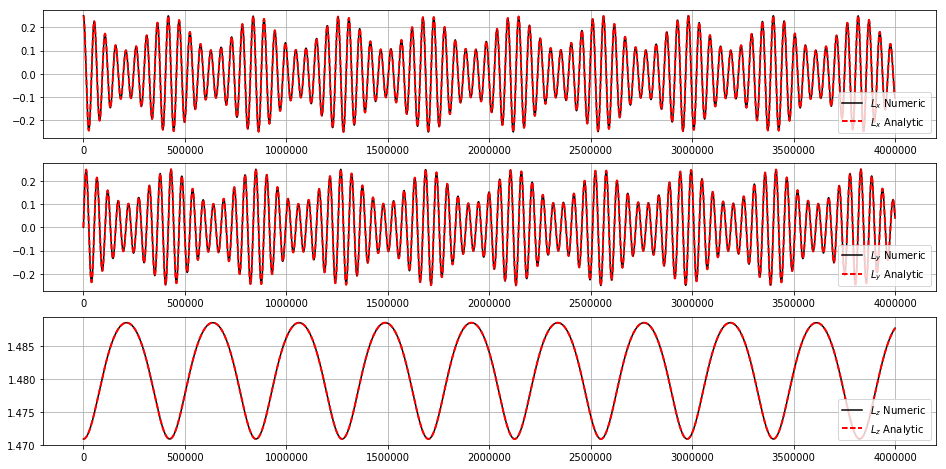

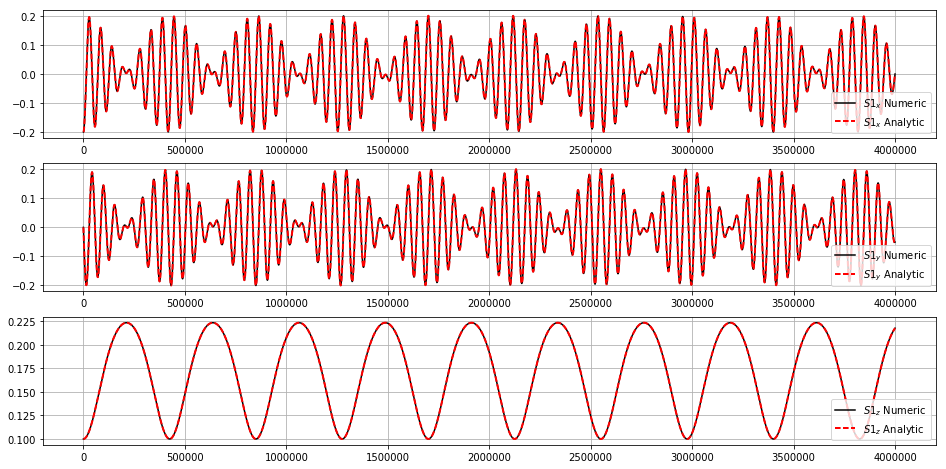

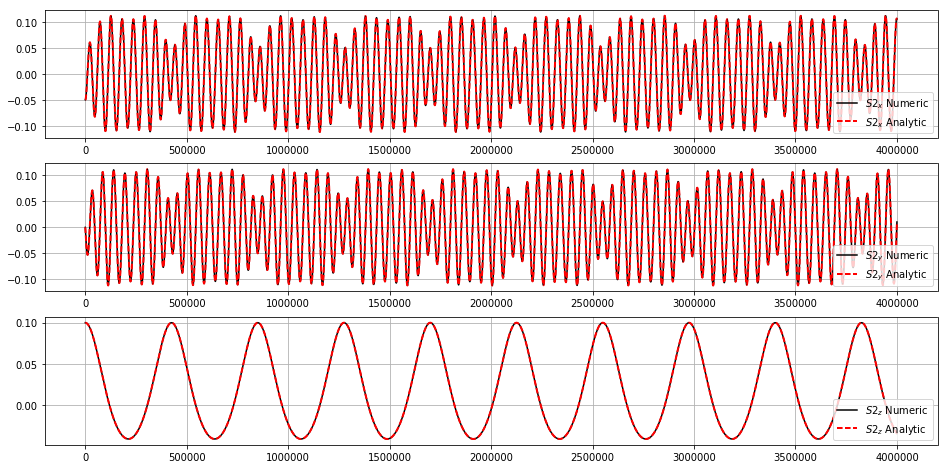

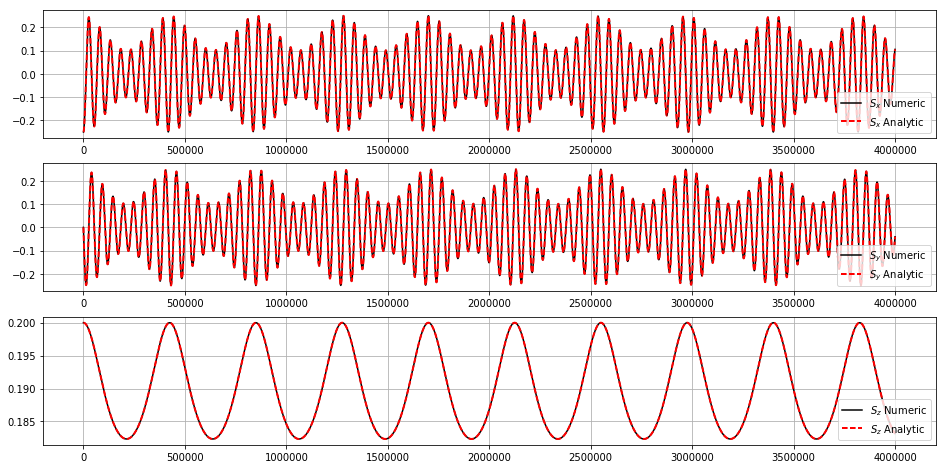

In [87]:
# fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 8))
# plot_comparison(ax1, t, num['Lx'], Lxoft, r'$L_x$')
# plot_comparison(ax2, t, num['Ly'], Lyoft, r'$L_y$')
# plot_comparison(ax3, t, num['Lz'], Lxoft, r'$L_z$')

# fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 8))
# plot_comparison(ax1, t, num['Sx'], Sxoft, r'$S_x$')
# plot_comparison(ax2, t, num['Sy'], Syoft, r'$S_y$')
# plot_comparison(ax3, t, num['Sz'], Sxoft, r'$S_z$')

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 8))
plot_comparison(ax1, t, num['Lx'], ana['Lx'], r'$L_x$')
plot_comparison(ax2, t, num['Ly'], ana['Ly'], r'$L_y$')
plot_comparison(ax3, t, num['Lz'], ana['Lz'], r'$L_z$')

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 8))
plot_comparison(ax1, t, num['S1x'], ana['S1x'], r'$S1_x$')
plot_comparison(ax2, t, num['S1y'], ana['S1y'], r'$S1_y$')
plot_comparison(ax3, t, num['S1z'], ana['S1z'], r'$S1_z$')

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 8))
plot_comparison(ax1, t, num['S2x'], ana['S2x'], r'$S2_x$')
plot_comparison(ax2, t, num['S2y'], ana['S2y'], r'$S2_y$')
plot_comparison(ax3, t, num['S2z'], ana['S2z'], r'$S2_z$')

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 8))
plot_comparison(ax1, t, num['Sx'], ana['Sx'], r'$S_x$')
plot_comparison(ax2, t, num['Sy'], ana['Sy'], r'$S_y$')
plot_comparison(ax3, t, num['Sz'], ana['Sz'], r'$S_z$')

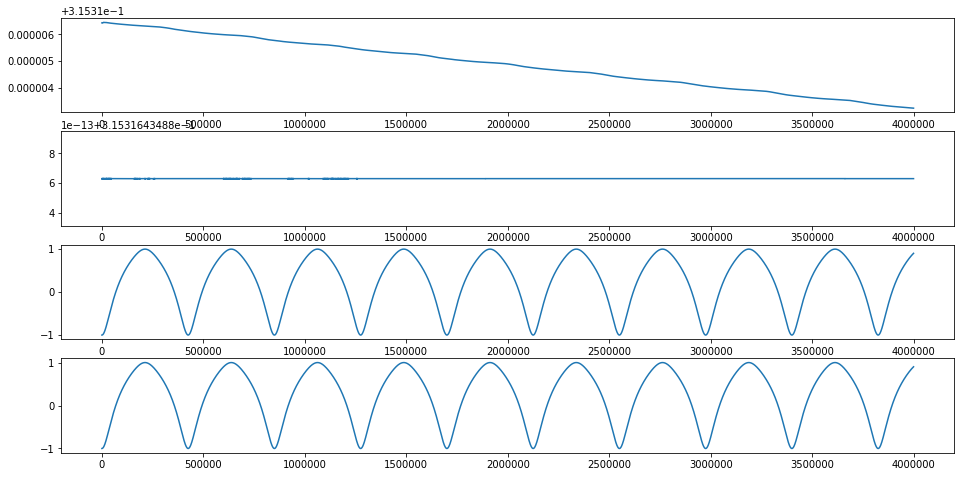

In [88]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(16, 8))

ax1.plot(t, num['xi'])
ax2.plot(t, ana['xi'])

cpp_num = cos_phi_prime_spin1_xyzprime(num['J'], num['L'], num['S'], num['S1'], num['S2'], q, num['xi'])
ax3.plot(t, cpp_num)

cpp_ana = cos_phi_prime_spin1_xyzprime(num['J'], num['L'], num['S'], num['S1'], num['S2'], q, ana['xi'])
ax4.plot(t, cpp_ana)

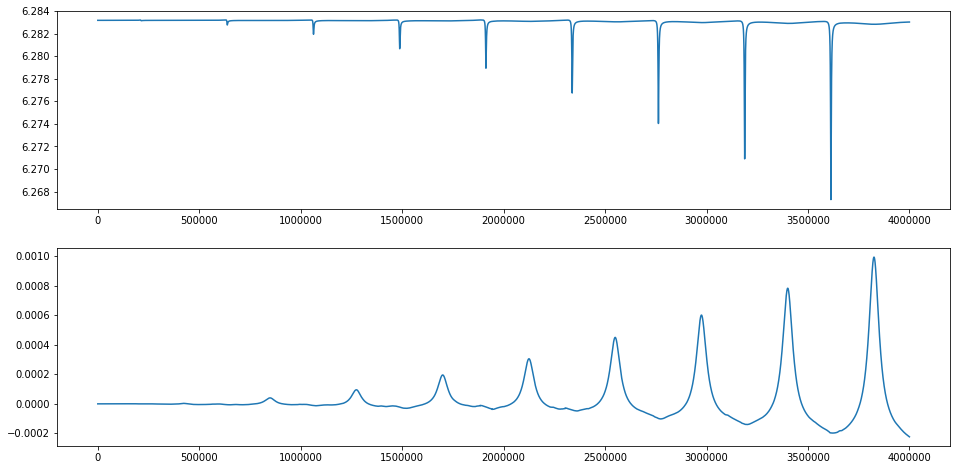

In [89]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 8))
ax1.plot(t, np.unwrap(num['phi_S1'])-np.unwrap(ana['phi_S1']))
ax2.plot(t, np.unwrap(num['phi_S2'])-np.unwrap(ana['phi_S2']))

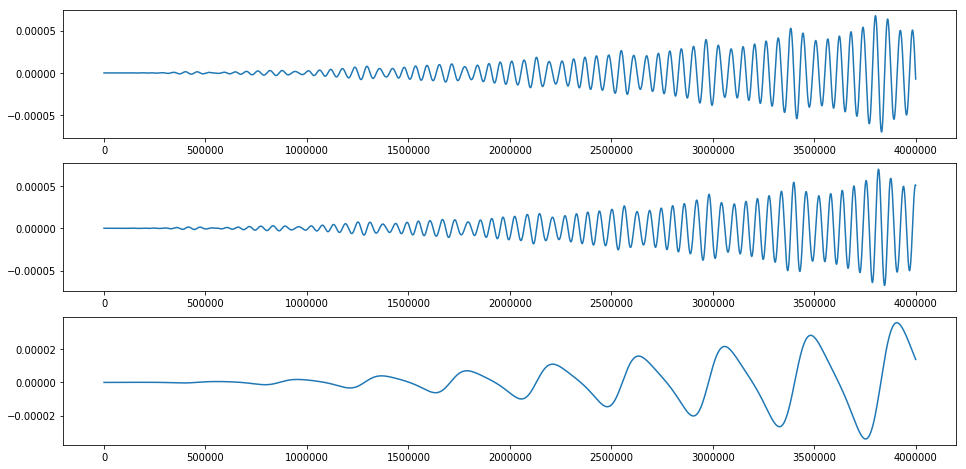

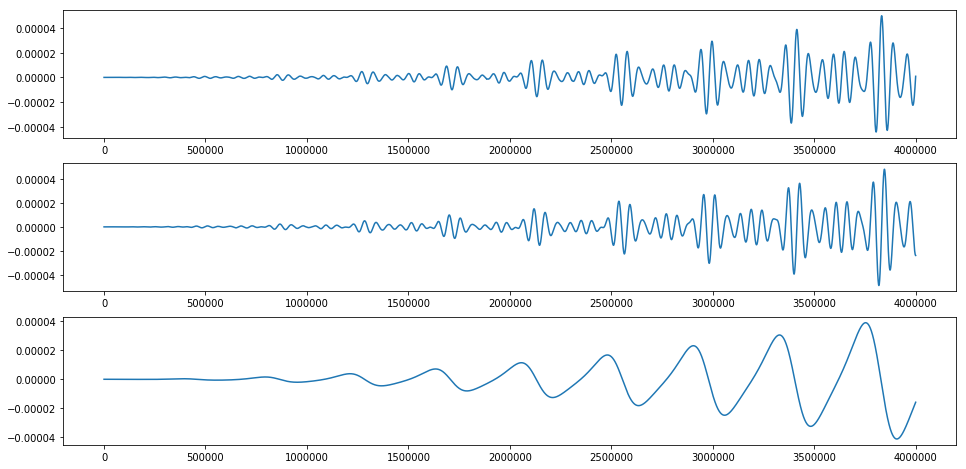

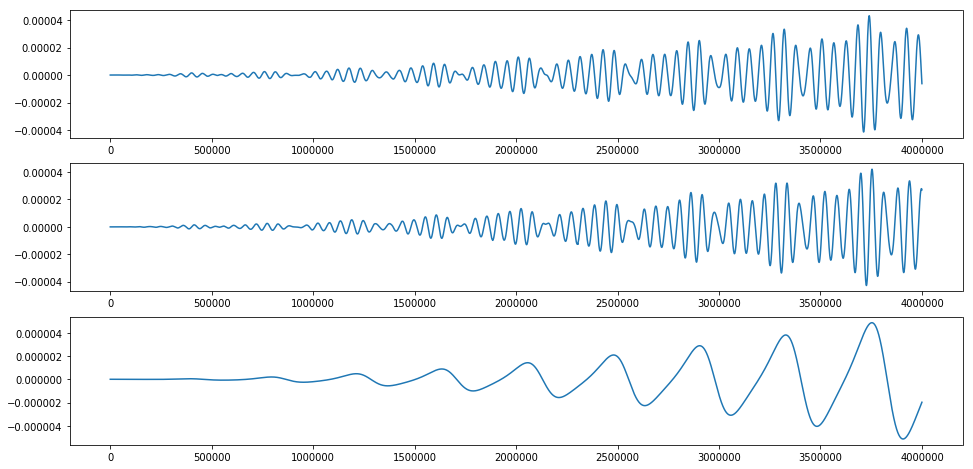

In [90]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 8))
ax1.plot(t, num['S1x']-ana['S1x'])
ax2.plot(t, num['S1y']-ana['S1y'])
ax3.plot(t, num['S1z']-ana['S1z'])

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 8))
ax1.plot(t, num['S2x']-ana['S2x'])
ax2.plot(t, num['S2y']-ana['S2y'])
ax3.plot(t, num['S2z']-ana['S2z'])

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 8))
ax1.plot(t, num['Sx']-ana['Sx'])
ax2.plot(t, num['Sy']-ana['Sy'])
ax3.plot(t, num['Sz']-ana['Sz'])

# Make animation

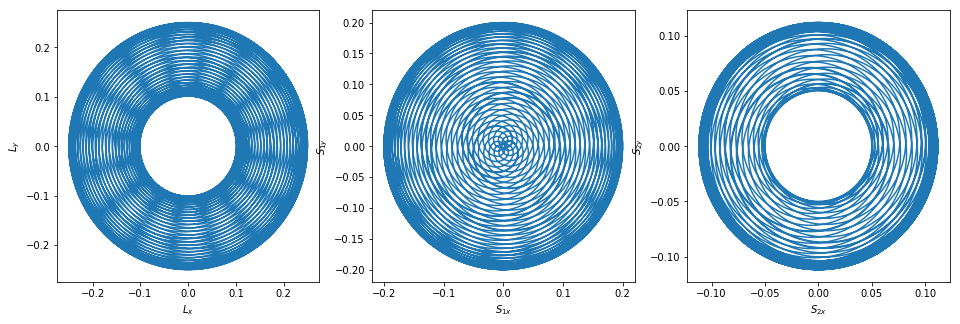

In [96]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
ax1.plot(ana['Lx'], ana['Ly'])
ax1.set_xlabel('$L_x$')
ax1.set_ylabel('$L_y$')

ax2.plot(ana['S1x'], ana['S1y'])
ax2.set_xlabel('$S_{1x}$')
ax2.set_ylabel('$S_{1y}$')

ax3.plot(ana['S2x'], ana['S2y'])
ax3.set_xlabel('$S_{2x}$')
ax3.set_ylabel('$S_{2y}$')

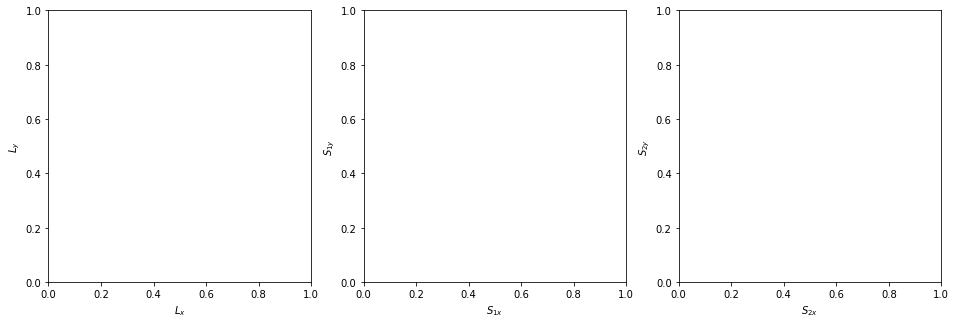

In [124]:
from matplotlib.animation import FuncAnimation

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

def init():
    ax1.set_xlabel('$L_x$')
    ax1.set_ylabel('$L_y$')
    #ax1.set_xlim(-0.5, 0.5)
    #ax1.set_ylim(-0.5, 0.5)
    
    ax2.set_xlabel('$S_{1x}$')
    ax2.set_ylabel('$S_{1y}$')
    #ax2.set_xlim(-0.5, 0.5)
    #ax2.set_ylim(-0.5, 0.5)
    
    ax3.set_xlabel('$S_{2x}$')
    ax3.set_ylabel('$S_{2y}$')
    #ax3.set_xlim(-0.5, 0.5)
    #ax3.set_ylim(-0.5, 0.5)

    
def func(i, ax1, ax2, ax3):
    ax1.cla()
    ax1.plot(ana['Lx'][:i], ana['Ly'][:i], c='k')
    ax1.set_xlim(-0.5, 0.5)
    ax1.set_ylim(-0.5, 0.5)
    
    ax2.cla()
    ax2.plot(ana['S1x'][:i], ana['S1y'][:i], c='r')
    ax2.set_xlim(-0.5, 0.5)
    ax2.set_ylim(-0.5, 0.5)
    
    ax3.cla()
    ax3.plot(ana['S2x'][:i], ana['S2y'][:i], c='g')
    ax3.set_xlim(-0.5, 0.5)
    ax3.set_ylim(-0.5, 0.5)

#init()
#func(100, ax1, ax2, ax3)
anim = FuncAnimation(fig, func, init_func=init, frames=np.arange(0, 10000, 10), interval=50, fargs=(ax1, ax2, ax3))

In [125]:
from IPython.display import HTML
HTML(anim.to_html5_video())

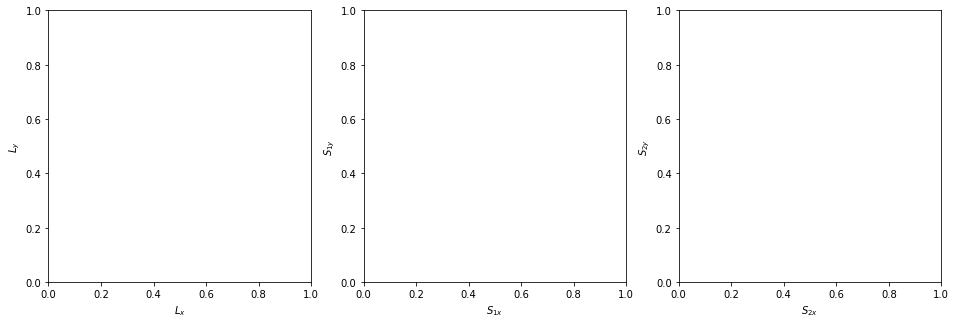

In [128]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

def func(i, ax1, ax2, ax3):
    ax1.cla()
    ax1.plot(ana['Lx'][:i], ana['Lz'][:i], c='k')
    ax1.set_xlim(-0.5, 0.5)
    ax1.set_ylim(-0.5, 0.5)
    
    ax2.cla()
    ax2.plot(ana['S1x'][:i], ana['S1z'][:i], c='r')
    ax2.set_xlim(-0.5, 0.5)
    ax2.set_ylim(-0.5, 0.5)
    
    ax3.cla()
    ax3.plot(ana['S2x'][:i], ana['S2z'][:i], c='g')
    ax3.set_xlim(-0.5, 0.5)
    ax3.set_ylim(-0.5, 0.5)

anim = FuncAnimation(fig, func, init_func=init, frames=np.arange(0, 1000, 10), interval=50, fargs=(ax1, ax2, ax3))

In [129]:
HTML(anim.to_html5_video())

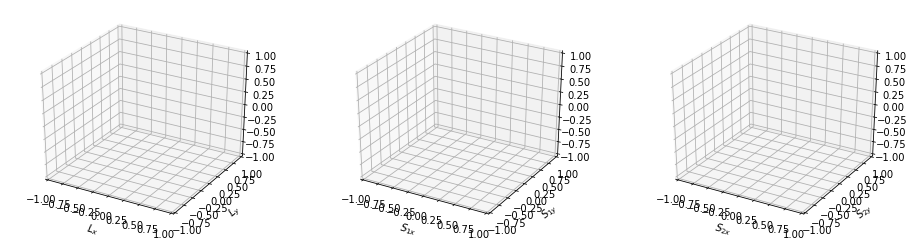

In [151]:
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(131, projection = '3d')
ax2 = fig.add_subplot(132, projection = '3d')
ax3 = fig.add_subplot(133, projection = '3d')

def init():
    ax1.set_xlabel('$L_x$')
    ax1.set_ylabel('$L_y$')
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_zlim(-1, 1)
    
    ax2.set_xlabel('$S_{1x}$')
    ax2.set_ylabel('$S_{1y}$')
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    ax2.set_zlim(-1, 1)
    
    ax3.set_xlabel('$S_{2x}$')
    ax3.set_ylabel('$S_{2y}$')
    ax3.set_xlim(-1, 1)
    ax3.set_ylim(-1, 1)
    ax3.set_zlim(-1, 1)
    
    
def func(i):
    ax1.cla()
    ax1.plot(ana['Lx'][:i], ana['Ly'][:i], ana['Lz'][:i], color = 'gray', lw=1)
    ax1.plot(ana['Lx'][max(0, i-100):i], ana['Ly'][max(0, i-100):i], ana['Lz'][max(0, i-100):i], color='r')
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_zlim(-1, 1)
    
    ax2.cla()
    ax2.plot(ana['S1x'][:i], ana['S1y'][:i], ana['S1z'][:i], color='gray', lw=1)
    ax2.plot(ana['S1x'][max(0, i-100):i], ana['S1y'][max(0, i-100):i], ana['S1z'][max(0, i-100):i], color='g')
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    ax2.set_zlim(-1, 1)
    
    ax3.cla()
    ax3.plot(ana['S2x'][:i], ana['S2y'][:i], ana['S2z'][:i], color='gray', lw=1)
    ax3.plot(ana['S2x'][max(0, i-100):i], ana['S2y'][max(0, i-100):i], ana['S2z'][max(0, i-100):i], color='b')
    ax3.set_xlim(-1, 1)
    ax3.set_ylim(-1, 1)
    ax3.set_zlim(-1, 1)
    
anim3d = FuncAnimation(fig, func, init_func=init, frames=np.arange(0, 1000, 30), interval=50)

In [152]:
HTML(anim3d.to_html5_video())

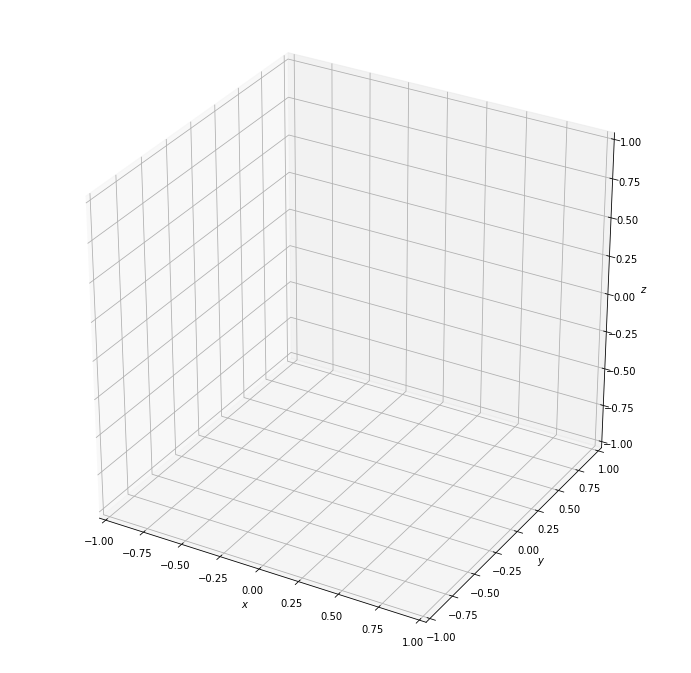

In [192]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(111, projection = '3d')


def init():
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    ax1.set_zlabel('$z$')
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_zlim(-1, 1)
    
    
def func(i):
    ax1.cla()
    
    u = np.linspace(0.0, 2*np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    
    x = ana['S2'][0] * np.outer(np.cos(u), np.sin(v))
    y = ana['S2'][0] * np.outer(np.sin(u), np.sin(v))
    z = ana['S2'][0] * np.outer(np.ones(np.size(u)), np.cos(v))
    ax1.plot_surface(x, y, z,  rstride=4, cstride=4, color='gray', linewidth=0, alpha=0.7)
    
    x = ana['S1'][0] * np.outer(np.cos(u), np.sin(v))
    y = ana['S1'][0] * np.outer(np.sin(u), np.sin(v))
    z = ana['S1'][0] * np.outer(np.ones(np.size(u)), np.cos(v))
    ax1.plot_surface(x, y, z,  rstride=4, cstride=4, color='gray', linewidth=0, alpha=0.3)
    
    x = ana['L'][0] * np.outer(np.cos(u), np.sin(v))
    y = ana['L'][0] * np.outer(np.sin(u), np.sin(v))
    z = ana['L'][0] * np.outer(np.ones(np.size(u)), np.cos(v))
    ax1.plot_surface(x, y, z,  rstride=4, cstride=4, color='gray', linewidth=0, alpha=0.1)
    
    ax1.plot(ana['S2x'][:i], ana['S2y'][:i], ana['S2z'][:i], color='b', lw=0.5)
    ax1.plot(ana['S2x'][max(0, i-100):i], ana['S2y'][max(0, i-100):i], ana['S2z'][max(0, i-100):i], color='b', lw=3)
    ax1.plot([0, ana['S2x'][i]], [0, ana['S2y'][i]], [0, ana['S2z'][i]], color='k')
    
    ax1.plot(ana['S1x'][:i], ana['S1y'][:i], ana['S1z'][:i], color='g', lw=0.5)
    ax1.plot(ana['S1x'][max(0, i-100):i], ana['S1y'][max(0, i-100):i], ana['S1z'][max(0, i-100):i], color='g', lw=3)
    ax1.plot([0, ana['S1x'][i]], [0, ana['S1y'][i]], [0, ana['S1z'][i]], color='k')
    
    ax1.plot(ana['Lx'][:i], ana['Ly'][:i], ana['Lz'][:i], color='r', lw=0.5)
    ax1.plot(ana['Lx'][max(0, i-100):i], ana['Ly'][max(0, i-100):i], ana['Lz'][max(0, i-100):i], color='r', lw=3)
    ax1.plot([0, ana['Lx'][i]], [0, ana['Ly'][i]], [0, ana['Lz'][i]], color='k')
    
    ax1.plot([0, 0], [0, 0], [0, ana['J'][0]], color='k')
    
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_zlim(-1, 1)
    
    # Get rid of the panes
    ax1.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax1.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax1.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    
    # Get rid of the spines
    ax1.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax1.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax1.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    
    # Get rid of the ticks
    ax1.set_xticks([]) 
    ax1.set_yticks([]) 
    ax1.set_zticks([])
    
#     # Add the labels
#     ax1.set_xlabel('$x$' )
#     ax1.set_ylabel('$y$')
#     ax1.set_zlabel('$z$')


anim3d = FuncAnimation(fig, func, init_func=init, frames=np.arange(0, 10000, 20), interval=50)

In [193]:
HTML(anim3d.to_html5_video())

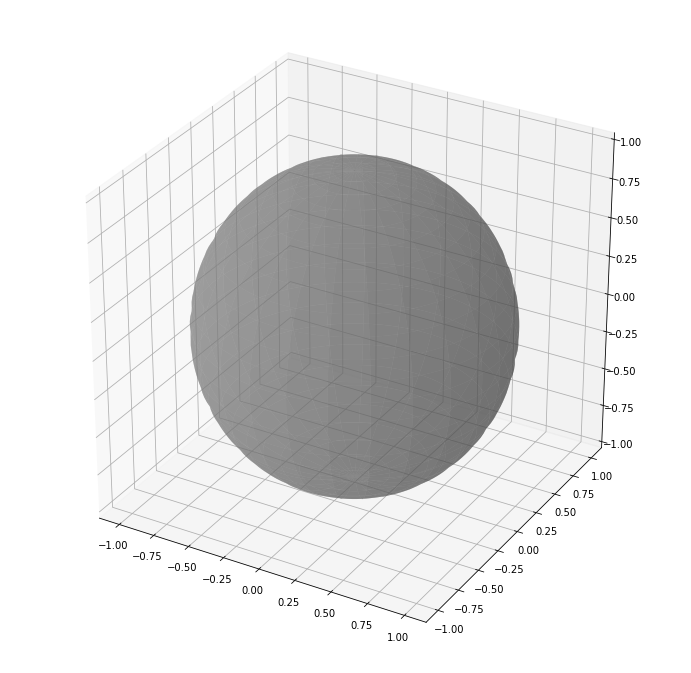

In [179]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection = '3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='gray', linewidth=0, alpha=0.5)

In [ ]:
# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
#ani.save('double_pendulum.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

# Junk

In [ ]:
# Cubic formula (Not working. See numerical recipies instead.)

a, b, c, d = 1., -30., 275., -750.

p = (3.*a*c - b**2) / (3.*a**2)
q = (2.*b**3 - 9.*a*b*c + 27.*a**2*d) / (27.*a**3)
print p, q

def tk(p, q, k):
    ac = np.arccos( 3.*q*np.sqrt(-3./p) / (2.*p) )
    return 2*np.sqrt(-p/3.) * np.cos( ac/3. - 2.*np.pi*k/3. )

print tk(p, q, 0), tk(p, q, 1), tk(p, q, 2)
print np.roots([a, b, c, d])

In [ ]:
S1x, S1y, S1z = 0.2, 0.3, 0.7

fig = plt.figure()
ax  = fig.add_subplot(111, projection = '3d')

ax.plot([0, S1x], [0, S1y], [0, Syz], color = 'r')